In [1]:
# Importing necessary packages, and classes adapted from decision boundary visualization studies

from huggingface_hub import hf_hub_download
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

import Models
import Attacks
import Tools
from ssnp import SSNP, visualize_decision_boundaries

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing MNIST dataset from online
data_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
MNIST_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

# pre-select adversarial examples
ADVERSARIAL_BATCH_N = 200
SEED = 42  # For reproducibility

torch.manual_seed(SEED)
random_indices = torch.randint(0, MNIST_data.data.shape[0], (ADVERSARIAL_BATCH_N,))

adversarial_images = MNIST_data.data[random_indices].float()
adversarial_labels = MNIST_data.targets[random_indices]

In [3]:
# Importing the MNIST classifier model
MODEL_SETTING = "small"

if MODEL_SETTING == "small":
    # Use SmallConvNet for MNIST classification
    MNIST_model = Models.SmallConvNet()
elif MODEL_SETTING == "normal":
    # Use ConvNet for MNIST classification
    MNIST_model = Models.ConvNet()

device_torch = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
    )


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
pts: [[-8.075387   -5.84959507]
 [-8.075387   -5.80219768]
 [-8.075387   -5.75480029]
 ...
 [ 8.14113998  8.22742984]
 [ 8.14113998  8.27482723]
 [ 8.14113998  8.32222462]]
x, y intervals: [-8.07538700e+00 -8.02115112e+00 -7.96691525e+00 -7.91267937e+00
 -7.85844350e+00 -7.80420762e+00 -7.74997174e+00 -7.69573587e+00
 -7.64149999e+00 -7.58726412e+00 -7.53302824e+00 -7.47879236e+00
 -7.42455649e+00 -7.37032061e+00 -7.31608473e+00 -7.26184886e+00
 -7.20761298e+00 -7.15337711e+00 -7.09914123e+00 -7.04490535e+00
 -6.99066948e+00 -6.93643360e+00 -6.88219772e+00 -6.82796185e+00
 -6.77372597e+00 -6.71949010e+00 -6.66525422e+00 -6.61101834e+00
 -6.55678247e+00 -6.50254659e+00 -6.44831071e+00 -6.39407484e+00
 -6.33983896e+00 -6.28560309e+00 -6.23136721e+00 -6.17713133e+00
 -6.12289546e+00 -6.06865958e+00 -6.01442371e+00 -5.96018783e+00
 -5.90595195e+00 -5.85171608e+00 -5.79748020e+00 -5.74324432e+00
 -5.68900845e+00

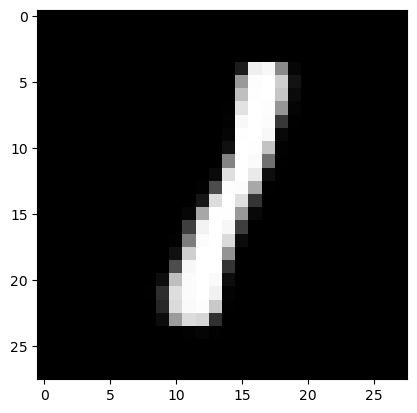

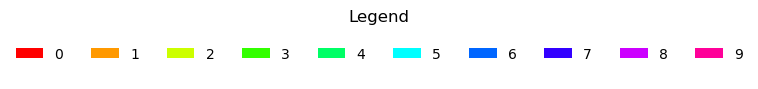

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
pts: [[-3.72231126 -4.36992598]
 [-3.72231126 -4.33996017]
 [-3.72231126 -4.30999436]
 ...
 [ 2.54030061  4.52991928]
 [ 2.54030061  4.55988509]
 [ 2.54030061  4.5898509 ]]
x, y intervals: [-3.72231126 -3.70136607 -3.68042088 -3.65947569 -3.6385305  -3.61758531
 -3.59664012 -3.57569493 -3.55474974 -3.53380455 -3.51285936 -3.49191417
 -3.47096898 -3.45002379 -3.4290786  -3.40813341 -3.38718822 -3.36624303
 -3.34529783 -3.32435264 -3.30340745 -3.28246226 -3.26151707 -3.24057188
 -3.21962669 -3.1986815  -3.17773631 -3.15679112 -3.13584593 -3.11490074
 -3.09395555 -3.07301036 -3.05206517 -3.03111998 -3.01017479 -2.9892296
 -2.96828441 -2.94733922 -2.92639403 -2.90544884 -2.88450365 -2.86355846
 -2.84261327 -2.82166808 -2.80072289 -2.7797777  -2.75883251 -2.73788732
 -2.71694213 -2.69599694 -2.67505175 -2.65410656 -2.63316137 -2.61221618
 -2.59127099 -2.5703258  -2.54938061 -2.52843542 -2.50749023 -2.48654504
 -2

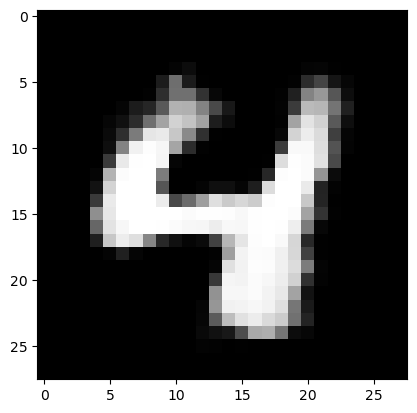

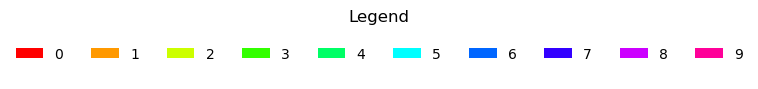

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
pts: [[-4.18909883 -5.16036892]
 [-4.18909883 -5.13110631]
 [-4.18909883 -5.1018437 ]
 ...
 [ 5.657197    3.53062664]
 [ 5.657197    3.55988925]
 [ 5.657197    3.58915186]]
x, y intervals: [-4.18909883 -4.15616808 -4.12323732 -4.09030657 -4.05737581 -4.02444506
 -3.9915143  -3.95858355 -3.92565279 -3.89272204 -3.85979128 -3.82686053
 -3.79392977 -3.76099902 -3.72806826 -3.69513751 -3.66220675 -3.62927599
 -3.59634524 -3.56341448 -3.53048373 -3.49755297 -3.46462222 -3.43169146
 -3.39876071 -3.36582995 -3.3328992  -3.29996844 -3.26703769 -3.23410693
 -3.20117618 -3.16824542 -3.13531467 -3.10238391 -3.06945315 -3.0365224
 -3.00359164 -2.97066089 -2.93773013 -2.90479938 -2.87186862 -2.83893787
 -2.80600711 -2.77307636 -2.7401456  -2.70721485 -2.67428409 -2.64135334
 -2.60842258 -2.57549183 -2.54256107 -2.50963031 -2.47669956 -2.4437688
 -2.41083805 -2.37790729 -2.34497654 -2.31204578 -2.27911503 -2.24618427
 -2.

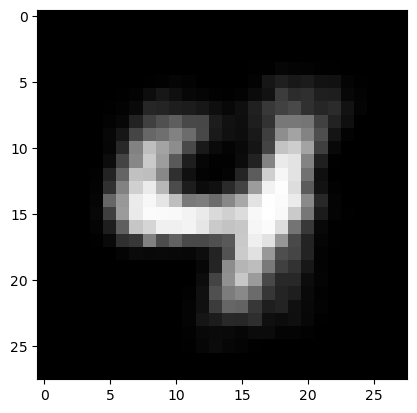

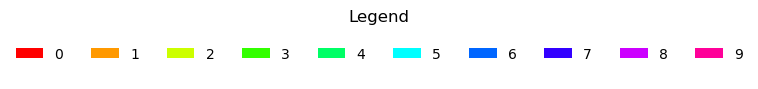

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
pts: [[-3.63555479 -2.74338174]
 [-3.63555479 -2.7188959 ]
 [-3.63555479 -2.69441007]
 ...
 [ 3.99960399  4.5289111 ]
 [ 3.99960399  4.55339693]
 [ 3.99960399  4.57788277]]
x, y intervals: [-3.63555479 -3.61001914 -3.58448349 -3.55894785 -3.5334122  -3.50787655
 -3.4823409  -3.45680525 -3.43126961 -3.40573396 -3.38019831 -3.35466266
 -3.32912701 -3.30359137 -3.27805572 -3.25252007 -3.22698442 -3.20144877
 -3.17591312 -3.15037748 -3.12484183 -3.09930618 -3.07377053 -3.04823488
 -3.02269924 -2.99716359 -2.97162794 -2.94609229 -2.92055664 -2.895021
 -2.86948535 -2.8439497  -2.81841405 -2.7928784  -2.76734276 -2.74180711
 -2.71627146 -2.69073581 -2.66520016 -2.63966452 -2.61412887 -2.58859322
 -2.56305757 -2.53752192 -2.51198627 -2.48645063 -2.46091498 -2.43537933
 -2.40984368 -2.38430803 -2.35877239 -2.33323674 -2.30770109 -2.28216544
 -2.25662979 -2.23109415 -2.2055585  -2.18002285 -2.1544872  -2.12895155
 -2.

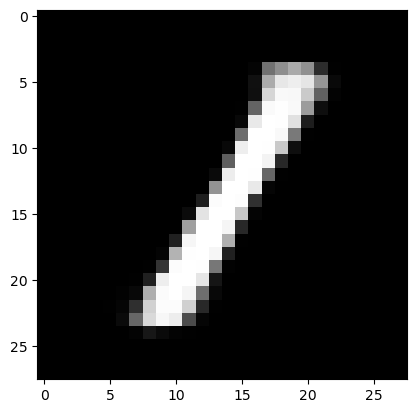

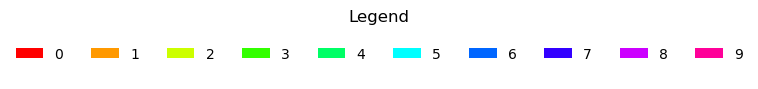

In [ ]:
# Loop through all trained models to produce adversarial examples
#MODELS = ["Constant", "Cyclic", "Exponential", "Linear", "LinearUniformMix", "Random"]
MODELS = ["Cyclic", "Exponential", "Linear", "LinearUniformMix"]
#MODELS = ["Constant"]
MODEL_REPO_ID = "JulienStal/MNIST-SmallConvs-AdversarialSchedulers"
EPSILON = 0.3
K = 10
BATCH_SIZE = 10000
EPOCHS = 200
PATIENCE = 50

SAVE_SSNP_HF = False
SSNP_REPO_ID = "JulienStal/SSNPs"

ssnps = []
im_grids = []
prob_grids = []
dbms = []
models = []
pts_arr = []

for model in MODELS:
    # Import the model weights from HuggingFace
    model_name = f"{MODEL_SETTING}_conv_{model}"
    model_file_name = f"model_{model}.pth"    
    local_pth_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename=model_file_name, force_download=True)    
    MNIST_model.load_state_dict(torch.load(local_pth_path, map_location=device_torch))

    for idx, (image, label) in enumerate(zip(adversarial_images, adversarial_labels)):
        if image.dim() == 2: image = image.unsqueeze(0).unsqueeze(0)
        elif image.dim() == 3: image = image.unsqueeze(0)
        label = torch.tensor([label])  # Make label a batch

        adv_image, perturbation = Attacks.pgd_attack(image, label, MNIST_model, nn.CrossEntropyLoss(), EPSILON, K, device_torch)
        adversarial_images[idx] = adv_image.squeeze()

    # Generate visualization
    ssnp_model_path = os.path.abspath(os.path.join(os.getcwd(), "../models/ssnp", f"ssnp_MNIST"))
    
    ssnp, im_grid, prob_grid, dbm, pts = visualize_decision_boundaries(
        original_dataset = MNIST_data,
        dataset_name = "MNIST",
        classifier_model = MNIST_model,
        classifier_model_name = model_name,
        ssnp_path_and_name = ssnp_model_path,
        batch_size = BATCH_SIZE,
        adversarial_images=adversarial_images,
        ssnp_training_epochs = EPOCHS,
        ssnp_training_patience = PATIENCE,
        verbose = False,
    )

    ssnps.append(ssnp)
    im_grids.append(im_grid)
    prob_grids.append(prob_grid)
    dbms.append(dbm)
    models.append(MNIST_model)
    pts_arr.append(pts)

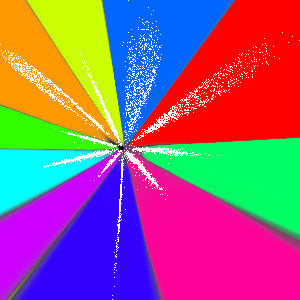

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Label of synthetic image at pixel (150, 150): 4.0 (confidence 0.92)


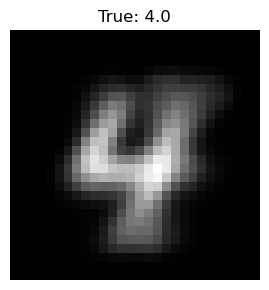

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.00 | 4: 0.69 | 5: 0.01 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.28


In [5]:
# Print the synthetic image for a given pixel
PIXEL_X, PIXEL_Y = (150, 150) # vertical and horizontal
index = PIXEL_X*300 + PIXEL_Y

ssnp = ssnps[0]
img_grid = im_grids[0]
prob_grid = prob_grids[0]
dbm = dbms[0]
model = models[0]
pts = pts_arr[0]

# Set pixel to red in the dbm and display
dbm.putpixel((PIXEL_Y, PIXEL_X), (255, 0, 0))  # Set pixel to red
display(dbm)

# Points values of the pixel
pt = pts[index]

# Get the synthetic image for the given pixel and print it
synthetic_img = torch.tensor(ssnp.inverse_transform(torch.tensor(pt).unsqueeze(0))).view(1, 1, 28, 28)
label_tensor = torch.tensor(img_grid[PIXEL_X][PIXEL_Y]).view(1,1)

# Print the label of the synthetic image
print(f"Label of synthetic image at pixel ({PIXEL_X}, {PIXEL_Y}): {label_tensor.item()} (confidence {prob_grid[PIXEL_X][PIXEL_Y]:.2f})")

Tools.plot_predictions(model, synthetic_img, label_tensor, device_torch, 1)